In [18]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [19]:
#NLP libraries
#import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.utils import shuffle

In [20]:
#load data from csv file
df = pd.read_csv('./data/ratings_BA_RB_sample.csv')

#show the dimensions of df
print(df.shape)

display(df.head())

(1551684, 33)


,beer_name,beer_id,style,abv,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,avg_computed,...,user_location,appearance,aroma,palate,taste,overall,rating,text,review,dataset
0,Dieu du Ciel Route des Épices,15138,Spice/Herb/Vegetable,5.0,1250.0,NaN,3.39,NaN,NaN,3.385442,...,"United States, Washington",4.00,7.00,4.0,7.00,14.00,3.60,12 oz. bottle; pours clear light brown with cr...,NaN,RB
1,Milton Geoptepe,46250,Premium Bitter/ESB,5.1,1944.0,NaN,2.83,NaN,NaN,2.900000,...,Australia,3.00,6.00,3.0,7.00,14.00,3.30,Cloudy copper with a lasting white head. Fresh...,NaN,RB
2,Mad Cow,58869,Milk / Sweet Stout,7.9,62.0,0.0,3.99,88.0,NaN,4.005240,...,"United States, Illinois",3.75,4.25,3.5,3.75,3.75,3.85,NaN,False,BA
3,Dark Apparition - Nuts,66032,Russian Imperial Stout,10.5,4048.0,0.0,4.25,91.0,NaN,4.120935,...,"United States, Connecticut",NaN,NaN,NaN,NaN,NaN,4.00,NaN,False,BA
4,Weyerbacher Verboten,118862,Belgian Ale,6.0,193.0,NaN,3.41,NaN,NaN,3.412018,...,"United States, New York",4.00,8.00,4.0,8.00,17.00,4.10,"Long Island, NY - 12 oz. bottle poured a cloud...",NaN,RB


In [21]:
# sentiment analysis of the column text

#start with first element
analyzer = SentimentIntensityAnalyzer()
scores = analyzer.polarity_scores(df['text'][0])
print(scores)

#only keep the columns text and rating
df_new = df[['text', 'rating']]


#remove NaN values
df_new = df_new.dropna()

#remove duplicates
df_new = df_new.drop_duplicates()

#reset index
df_new = df_new.reset_index(drop=True)

display(df_new.head())

# add the columns for the scores
df_new['compound'] = ''
df_new['neg'] = ''
df_new['neu'] = ''
df_new['pos'] = ''

#select the 10000 first lines
#df_short = df_new[:10000]

#select every 100th line
df_short = df_new[::100]
display(df_short)

{'neg': 0.082, 'neu': 0.758, 'pos': 0.161, 'compound': 0.8198}


,text,rating
0,12 oz. bottle; pours clear light brown with cr...,3.6
1,Cloudy copper with a lasting white head. Fresh...,3.3
2,"Long Island, NY - 12 oz. bottle poured a cloud...",4.1
3,Sample of a 50cl bottle at wwt3.Very thinwhite...,2.8
4,On tap at the Jopen beer festival.Medium white...,3.2


,text,rating,compound,neg,neu,pos
0,12 oz. bottle; pours clear light brown with cr...,3.6,,,,
100,(bottle - corked & caged 750 ml) Slightly hazy...,3.7,,,,
200,"This is, of course, a classic beer, and it is ...",3.9,,,,
300,Really a wonderful beer all around.,5.0,,,,
400,Was dit mijn eerste IPA. Wel veel bittersmaken...,3.4,,,,
...,...,...,...,...,...,...
983000,Poured from the can a very faint yellow with t...,3.5,,,,
983100,"Bottle, Lager glass. kind of fruity aroma, kin...",2.3,,,,
983200,colore nero impenetrabile con una schiuma beig...,3.9,,,,
983300,Pours pitch black with small tan head. Nose is...,4.0,,,,


In [22]:
#loop through the rows and add the scores to the columns

for index, row in df_short.iterrows():
    scores = analyzer.polarity_scores(row['text'])
    df_short.at[index, 'compound'] = scores['compound']
    df_short.at[index, 'neg'] = scores['neg']
    df_short.at[index, 'neu'] = scores['neu']
    df_short.at[index, 'pos'] = scores['pos']

display(df_short.head())


,text,rating,compound,neg,neu,pos
0,12 oz. bottle; pours clear light brown with cr...,3.6,0.8198,0.082,0.758,0.161
100,(bottle - corked & caged 750 ml) Slightly hazy...,3.7,-0.3213,0.135,0.768,0.097
200,"This is, of course, a classic beer, and it is ...",3.9,0.9913,0.021,0.811,0.167
300,Really a wonderful beer all around.,5.0,0.6096,0.0,0.557,0.443
400,Was dit mijn eerste IPA. Wel veel bittersmaken...,3.4,0.6369,0.0,0.833,0.167


C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2232864925.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_short['pos'], label='positive')
C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2232864925.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_short['neg'], label='negative')
C:\U

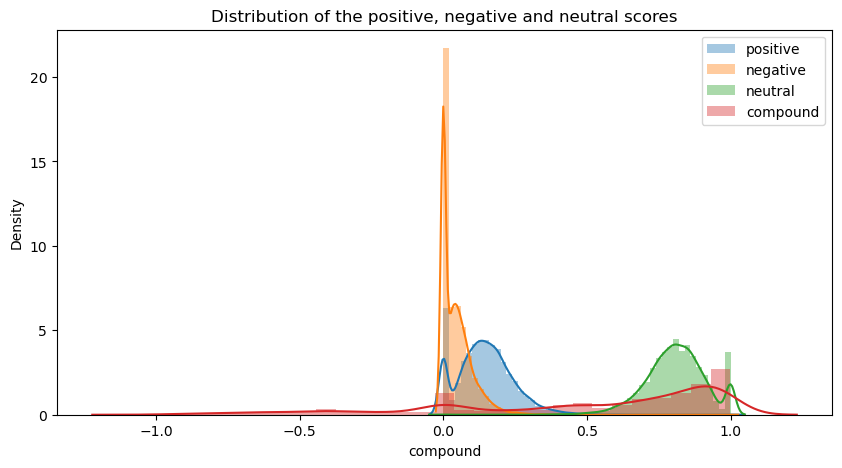

In [23]:
# plot the distribution of the positive, negative, neutral and compound scores
plt.figure(figsize=(10,5))
plt.title('Distribution of the positive, negative and neutral scores')
sns.distplot(df_short['pos'], label='positive')
sns.distplot(df_short['neg'], label='negative')
sns.distplot(df_short['neu'], label='neutral')
sns.distplot(df_short['compound'], label='compound')
plt.legend()
plt.show()


In [24]:
b_rev = 'this is the worst beer I have ever tasted'
g_rev = 'this is the best beer I have ever tasted'
print(analyzer.polarity_scores(b_rev))
print(analyzer.polarity_scores(g_rev))


{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.6369}


C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2108699360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['compound'] = df_short['compound'] + 1
C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2108699360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['compound'] = df_short['compound'] * 2.5
C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2108699360.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use eith

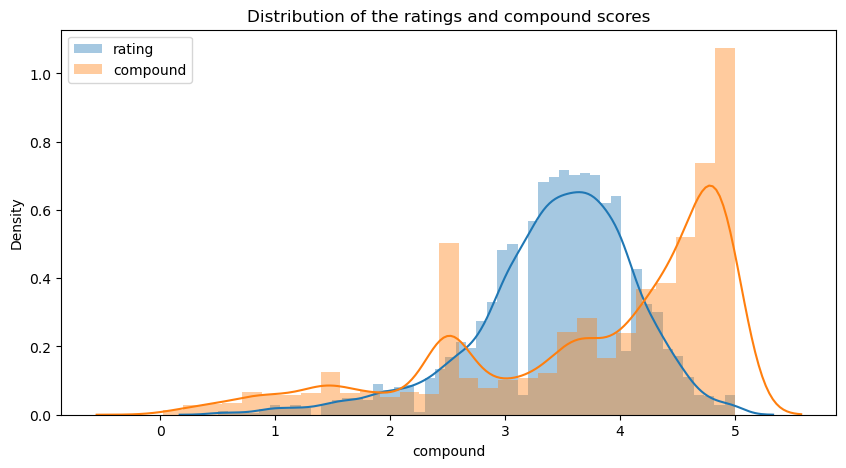

C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2108699360.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['neu'] = df_short['neu'] * 5
C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2108699360.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_short['rating'], label='rating')
C:\Users\ben\AppData\Local\Temp\ipykernel_17992\2108699360.py:22: UserWarning: 

`distplot` is a deprecate

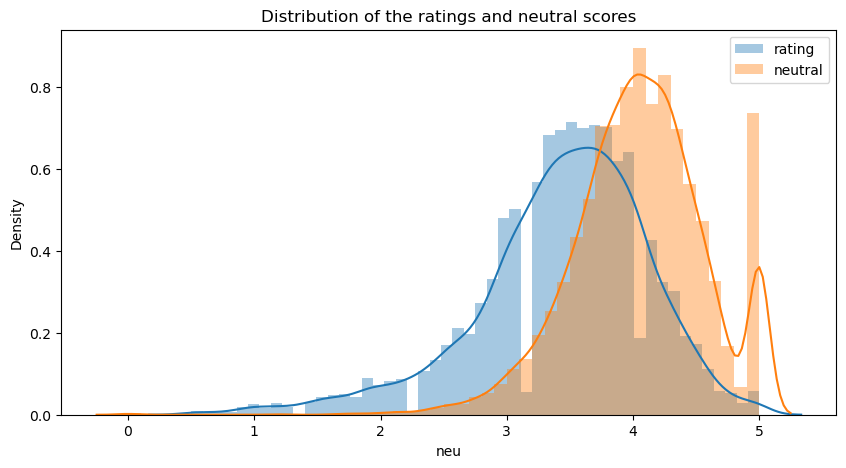

In [25]:
#normalize the compound scores to 0-5
df_short['compound'] = df_short['compound'] + 1
df_short['compound'] = df_short['compound'] * 2.5



# in df_short compare the columns rating and compound
plt.figure(figsize=(10,5))
plt.title('Distribution of the ratings and compound scores')
sns.distplot(df_short['rating'], label='rating')
sns.distplot(df_short['compound'], label='compound')
plt.legend()
plt.show()

#normalize neu to 0-5
df_short['neu'] = df_short['neu'] * 5

#compare the columns rating and neu
plt.figure(figsize=(10,5))
plt.title('Distribution of the ratings and neutral scores')
sns.distplot(df_short['rating'], label='rating')
sns.distplot(df_short['neu'], label='neutral')
plt.legend()
plt.show()

